# Late Interaction Multi-Vector Search Tutorial

## Introduction

This notebook demonstrates **late interaction** retrieval, a powerful approach where documents and queries are represented as multiple vectors (one per token or patch), and similarity is computed using **MaxSim** - taking the maximum similarity between each query vector and all document vectors.

We'll implement this from scratch in pure Python/NumPy, covering:
1. **ColBERTv2** for text retrieval
3. **Custom LLM embeddings** from any transformer model
4. **Visual highlighting** of relevant patches in documents

## Setup and Installation

In [ ]:
# Install required packages
!pip install torch transformers pillow numpy matplotlib

In [2]:
import torch
import numpy as np
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from transformers import AutoTokenizer, AutoModel
from colpali_engine.models import ColPali, ColPaliProcessor
import io

## Part 1: Core Late Interaction Implementation

### 1.1 MaxSim Calculation

The heart of late interaction is the **MaxSim** operation:

$$\text{MaxSim}(Q, D) = \sum_{i=1}^{|Q|} \max_{j=1}^{|D|} Q_i \cdot D_j$$

For each query vector, we find its maximum similarity with any document vector.


In [3]:
# simple version, showing just the math
def maxsim(query_vectors: np.ndarray, doc_vectors: np.ndarray) -> float:
    """
    Compute MaxSim score between query and document vectors.
    
    Args:
        query_vectors: Shape (num_query_tokens, embedding_dim)
        doc_vectors: Shape (num_doc_tokens, embedding_dim)
    
    Returns:
        MaxSim score (float)
    """
    # Compute all pairwise similarities: (num_query_tokens, num_doc_tokens)
    similarities = np.matmul(query_vectors, doc_vectors.T)
   
    # For each query vector, take max similarity with any doc vector
    max_similarities = np.max(similarities, axis=1)
    
    # Sum across all query vectors
    score = np.sum(max_similarities)
    
    return score


def maxsim_batch(query_vectors: np.ndarray, doc_vectors_list: List[np.ndarray]) -> np.ndarray:
    """
    Compute MaxSim scores between a query and multiple documents.
    
    Args:
        query_vectors: Shape (num_query_tokens, embedding_dim)
        doc_vectors_list: List of document vectors, each (num_doc_tokens, embedding_dim)
    
    Returns:
        Array of scores, one per document
    """
    scores = np.array([maxsim(query_vectors, doc_vecs) for doc_vecs in doc_vectors_list])
    return scores

In [4]:
# version with logging for understanding the steps
def maxsim(
    query_vectors: np.ndarray, 
    doc_vectors: np.ndarray,
    query_tokens: Optional[List[str]] = None,
    doc_tokens: Optional[List[str]] = None,
    log: bool = False
) -> float:
    """
    Compute MaxSim score between query and document vectors.
    
    Args:
        query_vectors: Shape (num_query_tokens, embedding_dim)
        doc_vectors: Shape (num_doc_tokens, embedding_dim)
        query_tokens: Optional list of query token strings (for logging)
        doc_tokens: Optional list of document token strings (for logging)
        log: If True, print detailed computation steps
    
    Returns:
        MaxSim score (float)
    """
    if log:
        print("\n" + "="*80)
        print("MAXSIM COMPUTATION (Detailed)")
        print("="*80)
        print(f"\nQuery vectors shape: {query_vectors.shape}")
        print(f"Document vectors shape: {doc_vectors.shape}")
        
        if query_tokens:
            print(f"\nQuery tokens ({len(query_tokens)}): {query_tokens}")
        if doc_tokens:
            print(f"Document tokens ({len(doc_tokens)}): {doc_tokens}")
    
    # Compute all pairwise similarities: (num_query_tokens, num_doc_tokens)
    similarities = np.matmul(query_vectors, doc_vectors.T)
    
    if log:
        print("\n" + "-"*80)
        print("STEP 1: Compute pairwise cosine similarities")
        print("-"*80)
        print(f"Similarity matrix shape: {similarities.shape}")
        print(f"(Each query token vs each document token)\n")
        
        # Print similarity matrix with labels
        if query_tokens and doc_tokens:
            # Print header
            header = "Query Token".ljust(20) + " | " + " | ".join([f"{dt[:8]:>8}" for dt in doc_tokens])
            print(header)
            print("-" * len(header))
            
            # Print each row
            for i, qt in enumerate(query_tokens):
                row_values = " | ".join([f"{similarities[i, j]:8.4f}" for j in range(len(doc_tokens))])
                print(f"{qt[:20]:20} | {row_values}")
        else:
            print("Similarity matrix:")
            print(similarities)
    
    # For each query vector, take max similarity with any doc vector
    max_similarities = np.max(similarities, axis=1)
    max_indices = np.argmax(similarities, axis=1)
    
    if log:
        print("\n" + "-"*80)
        print("STEP 2: For each query token, find maximum similarity with any doc token")
        print("-"*80)
        
        if query_tokens and doc_tokens:
            for i, qt in enumerate(query_tokens):
                matched_doc_token = doc_tokens[max_indices[i]]
                print(f"Query token '{qt[:20]:20}' -> Doc token '{matched_doc_token[:20]:20}' | Max sim: {max_similarities[i]:.4f}")
        else:
            print("Max similarities per query token:")
            for i, max_sim in enumerate(max_similarities):
                print(f"  Query token {i}: {max_sim:.4f} (matched with doc token {max_indices[i]})")
    
    # Sum across all query vectors
    score = np.sum(max_similarities)
    
    if log:
        print("\n" + "-"*80)
        print("STEP 3: Sum all maximum similarities")
        print("-"*80)
        print(f"MaxSim score = sum of max similarities")
        print(f"             = {' + '.join([f'{ms:.4f}' for ms in max_similarities[:5]])}" + 
              (f" + ... ({len(max_similarities)-5} more)" if len(max_similarities) > 5 else ""))
        print(f"             = {score:.4f}")
        print("="*80 + "\n")
    
    return score


def maxsim_batch(
    query_vectors: np.ndarray, 
    doc_vectors_list: List[np.ndarray],
    query_tokens: Optional[List[str]] = None,
    doc_tokens_list: Optional[List[List[str]]] = None,
    log: bool = False
) -> np.ndarray:
    """
    Compute MaxSim scores between a query and multiple documents.
    
    Args:
        query_vectors: Shape (num_query_tokens, embedding_dim)
        doc_vectors_list: List of document vectors, each (num_doc_tokens, embedding_dim)
        query_tokens: Optional list of query token strings (for logging)
        doc_tokens_list: Optional list of document token lists (for logging)
        log: If True, print detailed computation for each document
    
    Returns:
        Array of scores, one per document
    """
    scores = []
    for i, doc_vecs in enumerate(doc_vectors_list):
        doc_toks = doc_tokens_list[i] if doc_tokens_list else None
        
        if log:
            print(f"\n{'='*80}")
            print(f"DOCUMENT {i+1}/{len(doc_vectors_list)}")
            print(f"{'='*80}")
        
        score = maxsim(
            query_vectors, 
            doc_vecs,
            query_tokens=query_tokens,
            doc_tokens=doc_toks,
            log=log
        )
        scores.append(score)
    
    return np.array(scores)

### 1.2 Multi-Vector Index

A simple index to store and search multi-vector representations:

In [5]:
@dataclass
class MultiVectorIndex:
    """Index for storing and searching multi-vector document representations."""
    
    doc_ids: List[str]
    doc_vectors: List[np.ndarray]  # List of (num_tokens, embedding_dim) arrays
    doc_metadata: List[Dict]  # Optional metadata per document
    
    def __init__(self):
        self.doc_ids = []
        self.doc_vectors = []
        self.doc_metadata = []
    
    def add_document(self, doc_id: str, vectors: np.ndarray, metadata: Optional[Dict] = None):
        """
        Add a document to the index.
        
        Args:
            doc_id: Unique identifier for the document
            vectors: Multi-vector representation, shape (num_tokens, embedding_dim)
            metadata: Optional metadata dictionary
        """
        self.doc_ids.append(doc_id)
        self.doc_vectors.append(vectors)
        self.doc_metadata.append(metadata or {})
    
    def search(
        self, 
        query_vectors: np.ndarray, 
        top_k: int = 10,
        query_tokens: Optional[List[str]] = None,
        log: bool = False
    ) -> List[Tuple[str, float, Dict]]:
        """
        Search for top-k most similar documents.
        
        Args:
            query_vectors: Query multi-vector representation, shape (num_query_tokens, embedding_dim)
            top_k: Number of results to return
            query_tokens: Optional list of query token strings (for logging)
            log: If True, print detailed MaxSim computation for each document
        
        Returns:
            List of (doc_id, score, metadata) tuples, sorted by score descending
        """
        if len(self.doc_ids) == 0:
            return []
        
        # Extract doc tokens from metadata if available
        doc_tokens_list = None
        if log and query_tokens:
            doc_tokens_list = [meta.get('tokens', None) for meta in self.doc_metadata]
        
        # Compute scores for all documents
        scores = maxsim_batch(
            query_vectors, 
            self.doc_vectors,
            query_tokens=query_tokens,
            doc_tokens_list=doc_tokens_list,
            log=log
        )
        
        # Get top-k indices
        top_indices = np.argsort(scores)[::-1][:top_k]
        
        # Return results
        results = [
            (self.doc_ids[idx], float(scores[idx]), self.doc_metadata[idx])
            for idx in top_indices
        ]
        
        return results
    
    def save(self, filepath: str):
        """Save index to disk."""
        np.savez(
            filepath,
            doc_ids=np.array(self.doc_ids, dtype=object),
            doc_vectors=np.array(self.doc_vectors, dtype=object),
            doc_metadata=np.array(self.doc_metadata, dtype=object)
        )
    
    @classmethod
    def load(cls, filepath: str):
        """Load index from disk."""
        data = np.load(filepath, allow_pickle=True)
        index = cls()
        index.doc_ids = data['doc_ids'].tolist()
        index.doc_vectors = data['doc_vectors'].tolist()
        index.doc_metadata = data['doc_metadata'].tolist()
        return index

## Part 2: ColBERTv2 Implementation

ColBERT uses a BERT model with a linear projection to create token-level embeddings.


In [6]:
class ColBERTEncoder:
    """ColBERTv2-style encoder for text documents."""
    
    def __init__(self, model_name: str = "colbert-ir/colbertv2.0", device: str = None):
        """
        Initialize ColBERT encoder.
        
        Args:
            model_name: HuggingFace model name or path
            device: Device to use ('cuda' or 'cpu')
        """
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device)
        self.model.eval()
        
        # ColBERT typically uses 128 dimensions
        self.embedding_dim = 128
    
    def encode_text(self, text: str, is_query: bool = False, max_length: int = 512) -> np.ndarray:
        """
        Encode text into multi-vector representation.
        
        Args:
            text: Input text
            is_query: Whether this is a query (adds [Q] token) or document
            max_length: Maximum sequence length
        
        Returns:
            Multi-vector representation, shape (num_tokens, embedding_dim)
        """
        # Add query marker if needed
        if is_query:
            text = "[Q] " + text
        
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=max_length,
            truncation=True,
            padding='max_length'
        ).to(self.device)
        
        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            # Use last hidden state
            embeddings = outputs.last_hidden_state.squeeze(0)  # (seq_len, hidden_dim)
        
        # Get attention mask to filter padding tokens
        attention_mask = inputs['attention_mask'].squeeze(0).cpu().numpy()
        
        # Filter out padding tokens
        embeddings = embeddings[attention_mask == 1].cpu().numpy()
        
        # Normalize embeddings (important for cosine similarity)
        embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
        
        return embeddings
    
    def encode_batch(self, texts: List[str], is_query: bool = False, max_length: int = 512) -> List[np.ndarray]:
        """Encode multiple texts."""
        return [self.encode_text(text, is_query=is_query, max_length=max_length) for text in texts]

### Demo ColbertV2 Search

In [7]:
# Example usage
def demo_colbert():
    """Demonstrate ColBERT encoding and search."""
    print("=== ColBERT Demo ===\n")
    
    # Initialize encoder
    encoder = ColBERTEncoder()
    
    # Sample documents
    documents = [
        "The capital of France is Paris, a beautiful city known for art and culture.",
        "Python is a popular programming language used for data science and web development.",
        "Machine learning models can be trained on large datasets to perform various tasks.",
        "The Eiffel Tower is located in Paris and is one of the most visited monuments.",
        "Deep learning is a subset of machine learning based on artificial neural networks."
    ]
    
    # Create index
    index = MultiVectorIndex()
    
    print("Indexing documents...")
    for i, doc in enumerate(documents):
        doc_vectors = encoder.encode_text(doc, is_query=False)
        index.add_document(
            doc_id=f"doc_{i}",
            vectors=doc_vectors,
            metadata={"text": doc}
        )
        print(f"  Doc {i}: {doc_vectors.shape[0]} tokens, {doc_vectors.shape[1]} dims")
    
    # Query
    query = "What is the capital of France?"
    print(f"\nQuery: '{query}'")
    
    query_vectors = encoder.encode_text(query, is_query=True)
    print(f"Query vectors: {query_vectors.shape[0]} tokens, {query_vectors.shape[1]} dims")
    
    # Search
    results = index.search(query_vectors, top_k=3)
    
    print("\nTop 3 Results:")
    for rank, (doc_id, score, metadata) in enumerate(results, 1):
        print(f"\n{rank}. {doc_id} (score: {score:.4f})")
        print(f"   {metadata['text']}")
        
# Uncomment to run:
demo_colbert()

=== ColBERT Demo ===

Indexing documents...
  Doc 0: 18 tokens, 768 dims
  Doc 1: 16 tokens, 768 dims
  Doc 2: 18 tokens, 768 dims
  Doc 3: 20 tokens, 768 dims
  Doc 4: 16 tokens, 768 dims

Query: 'What is the capital of France?'
Query vectors: 12 tokens, 768 dims

Top 3 Results:

1. doc_0 (score: 9.9879)
   The capital of France is Paris, a beautiful city known for art and culture.

2. doc_3 (score: 7.3325)
   The Eiffel Tower is located in Paris and is one of the most visited monuments.

3. doc_1 (score: 5.1174)
   Python is a popular programming language used for data science and web development.


## Part 3: Custom LLM Multi-Vector Encoder

Use any transformer model's last layer embeddings to create multi-vector representations.

In [8]:
class CustomLLMEncoder:
    """Generic multi-vector encoder using any transformer model."""
    
    def __init__(
        self,
        model_name: str = "bert-base-uncased",
        layer: int = -1,
        pooling: str = "none",
        device: str = None,
        skip_special_tokens: bool = True
    ):
        """
        Initialize custom LLM encoder.
        
        Args:
            model_name: HuggingFace model name
            layer: Which layer to use (-1 for last layer)
            pooling: Pooling strategy ('none', 'mean', 'max', 'cls')
            device: Device to use
            skip_special_tokens: If True, filter out special tokens ([CLS], [SEP], [PAD], etc.)
                                from multi-vector representations to prevent them from dominating
        """
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True).to(self.device)
        self.model.eval()
        
        self.layer = layer
        self.pooling = pooling
        self.model_name = model_name
        self.skip_special_tokens = skip_special_tokens
        
        # Get special token IDs for filtering
        self.special_token_ids = set(self.tokenizer.all_special_ids)
    
    def encode_text(
        self,
        text: str,
        max_length: int = 512,
        return_tokens: bool = False
    ) -> np.ndarray:
        """
        Encode text into multi-vector representation.
        
        Args:
            text: Input text
            max_length: Maximum sequence length
            return_tokens: Whether to return token strings
        
        Returns:
            Multi-vector representation, shape (num_tokens, embedding_dim)
            If return_tokens=True, returns (embeddings, token_strings)
        """
        # Tokenize
        inputs = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=max_length,
            truncation=True,
            padding='max_length'
        )
        
        # Store token IDs for later if needed
        input_ids = inputs['input_ids'].clone()
        attention_mask = inputs['attention_mask'].clone()
        
        # Move inputs to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Get embeddings
        with torch.no_grad():
            outputs = self.model(**inputs)
            
            # Extract embeddings from specified layer
            if hasattr(outputs, 'hidden_states') and outputs.hidden_states is not None:
                # Use hidden states from specific layer
                embeddings = outputs.hidden_states[self.layer].squeeze(0)
            else:
                # Fallback to last_hidden_state
                embeddings = outputs.last_hidden_state.squeeze(0)
        
        # Get attention mask to filter padding tokens
        attention_mask_np = attention_mask.squeeze(0).cpu().numpy()
        
        # Get token IDs for filtering special tokens
        token_ids = input_ids.squeeze(0).cpu().numpy()
        
        # Create mask for valid tokens (non-padding and optionally non-special)
        valid_mask = attention_mask_np == 1
        if self.skip_special_tokens:
            # Filter out special tokens
            special_mask = np.array([tid not in self.special_token_ids for tid in token_ids])
            valid_mask = valid_mask & special_mask
        
        # Filter embeddings and token IDs
        embeddings = embeddings.cpu().numpy()
        embeddings = embeddings[valid_mask]
        token_ids_filtered = token_ids[valid_mask]
        
        # Handle edge case: if all tokens were filtered out, keep at least one
        if len(embeddings) == 0:
            # Fall back to keeping all non-padding tokens
            valid_mask = attention_mask_np == 1
            embeddings = embeddings[valid_mask]
            token_ids_filtered = token_ids[valid_mask]
        
        # Apply pooling if specified
        if self.pooling == "mean":
            embeddings = np.mean(embeddings, axis=0, keepdims=True)
        elif self.pooling == "max":
            embeddings = np.max(embeddings, axis=0, keepdims=True)
        elif self.pooling == "cls":
            embeddings = embeddings[0:1]  # Keep only [CLS] token
        # else: pooling == "none", keep all token embeddings
        
        # Normalize embeddings
        embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
        
        if return_tokens:
            # Get token strings
            tokens = [self.tokenizer.decode([tid]) for tid in token_ids_filtered]
            return embeddings, tokens
        
        return embeddings
    
    def encode_batch(self, texts: List[str], max_length: int = 512) -> List[np.ndarray]:
        """Encode multiple texts."""
        return [self.encode_text(text, max_length=max_length) for text in texts]
    
    def analyze_token_contributions(
        self,
        query: str,
        document: str,
        top_k: int = 10
    ) -> Dict:
        """
        Analyze which query tokens contribute most to document similarity.
        
        Args:
            query: Query text
            document: Document text
            top_k: Number of top contributing tokens to return
        
        Returns:
            Dictionary with analysis results
        """
        # Encode with token information
        query_vectors, query_tokens = self.encode_text(query, return_tokens=True)
        doc_vectors = self.encode_text(document)
        
        # Compute similarity matrix
        similarities = np.matmul(query_vectors, doc_vectors.T)
        
        # For each query token, get its max similarity
        max_sims = np.max(similarities, axis=1)
        
        # Get top-k contributing tokens
        top_indices = np.argsort(max_sims)[::-1][:top_k]
        
        results = {
            'total_score': np.sum(max_sims),
            'query_tokens': query_tokens,
            'token_contributions': [
                {
                    'token': query_tokens[idx],
                    'score': float(max_sims[idx]),
                    'percentage': float(max_sims[idx] / np.sum(max_sims) * 100)
                }
                for idx in top_indices
            ]
        }
        
        return results

In [9]:
# Example usage
def demo_custom_llm():
    """Demonstrate custom LLM encoder."""
    print("=== Custom LLM Encoder Demo ===\n")
    
    # Try different models
    models_to_try = [
        ("bert-base-uncased", "BERT Base"),
        # ("roberta-base", "RoBERTa Base"),
        # ("microsoft/deberta-v3-base", "DeBERTa v3"),
    ]
    
    documents = [
        "The Eiffel Tower is a wrought-iron lattice tower in Paris, France.",
        "Python is widely used in machine learning and data science applications.",
        "Neural networks are computing systems inspired by biological neural networks.",
    ]
    
    query = "What are famous landmarks in Paris?"
    
    for model_name, model_display in models_to_try:
        print(f"\n--- Using {model_display} ---")
        
        # Initialize encoder
        encoder = CustomLLMEncoder(model_name=model_name)
        
        # Create index
        index = MultiVectorIndex()
        
        for i, doc in enumerate(documents):
            doc_vectors = encoder.encode_text(doc)
            index.add_document(
                doc_id=f"doc_{i}",
                vectors=doc_vectors,
                metadata={"text": doc}
            )
        
        # Query
        query_vectors = encoder.encode_text(query)
        results = index.search(query_vectors, top_k=2)
        
        print(f"\nQuery: '{query}'")
        print(f"Query shape: {query_vectors.shape}")
        print("\nTop 2 Results:")
        for rank, (doc_id, score, metadata) in enumerate(results, 1):
            print(f"  {rank}. {doc_id} (score: {score:.4f})")
            print(f"     {metadata['text'][:80]}...")
        
        # Analyze token contributions for top result
        if results:
            top_doc = results[0][2]['text']
            analysis = encoder.analyze_token_contributions(query, top_doc, top_k=5)
            
            print(f"\nToken Contribution Analysis:")
            print(f"Total MaxSim Score: {analysis['total_score']:.4f}")
            print("\nTop Contributing Query Tokens:")
            for contrib in analysis['token_contributions']:
                print(f"  '{contrib['token']}': {contrib['score']:.4f} ({contrib['percentage']:.1f}%)")

# Uncomment to run:
demo_custom_llm()

=== Custom LLM Encoder Demo ===


--- Using BERT Base ---

Query: 'What are famous landmarks in Paris?'
Query shape: (7, 768)

Top 2 Results:
  1. doc_0 (score: 3.3440)
     The Eiffel Tower is a wrought-iron lattice tower in Paris, France....
  2. doc_2 (score: 2.9156)
     Neural networks are computing systems inspired by biological neural networks....

Token Contribution Analysis:
Total MaxSim Score: 3.3440

Top Contributing Query Tokens:
  'paris': 0.7696 (23.0%)
  'in': 0.6568 (19.6%)
  'famous': 0.4749 (14.2%)
  'landmarks': 0.4625 (13.8%)
  'are': 0.3680 (11.0%)


## Part 4: Show Detailed MaxSim Calculation

In [10]:
def demo_maxsim_logging():
    """Demonstrate MaxSim computation with detailed logging."""
    print("=== MaxSim Detailed Logging Demo ===\n")
    
    # Initialize encoder
    encoder = CustomLLMEncoder(model_name="bert-base-uncased")
    
    # Simple example
    query = "Paris France"
    document = "The capital of France is Paris"
    
    print(f"Query: '{query}'")
    print(f"Document: '{document}'")
    
    # Encode with tokens
    query_vectors, query_tokens = encoder.encode_text(query, return_tokens=True)
    doc_vectors, doc_tokens = encoder.encode_text(document, return_tokens=True)
    
    # Compute MaxSim with detailed logging
    score = maxsim(
        query_vectors, 
        doc_vectors,
        query_tokens=query_tokens,
        doc_tokens=doc_tokens,
        log=True
    )
    
    print(f"\n🎯 Final MaxSim Score: {score:.4f}")
    print("\nInterpretation:")
    print(f"  - Higher scores indicate better semantic match")
    print(f"  - Each query token found its best match in the document")
    print(f"  - The score is the sum of these best matches")

# Uncomment to run:
demo_maxsim_logging()

=== MaxSim Detailed Logging Demo ===

Query: 'Paris France'
Document: 'The capital of France is Paris'

MAXSIM COMPUTATION (Detailed)

Query vectors shape: (2, 768)
Document vectors shape: (6, 768)

Query tokens (2): ['paris', 'france']
Document tokens (6): ['the', 'capital', 'of', 'france', 'is', 'paris']

--------------------------------------------------------------------------------
STEP 1: Compute pairwise cosine similarities
--------------------------------------------------------------------------------
Similarity matrix shape: (2, 6)
(Each query token vs each document token)

Query Token          |      the |  capital |       of |   france |       is |    paris
--------------------------------------------------------------------------------------
paris                |   0.3259 |   0.3671 |   0.3332 |   0.4532 |   0.3094 |   0.5212
france               |   0.2147 |   0.2375 |   0.2101 |   0.4179 |   0.2414 |   0.7248

------------------------------------------------------------

## Part 5: Visual Analysis

### Similarity Heatmap

In [11]:
def plot_similarity_heatmap(
    query_vectors: np.ndarray,
    doc_vectors: np.ndarray,
    query_tokens: List[str],
    doc_tokens: List[str],
    title: str = "Token Similarity Heatmap"
):
    """
    Plot heatmap of similarities between query and document tokens.
    
    Args:
        query_vectors: Shape (num_query_tokens, embedding_dim)
        doc_vectors: Shape (num_doc_tokens, embedding_dim)
        query_tokens: List of query token strings
        doc_tokens: List of document token strings
        title: Plot title
    """
    # Compute similarity matrix
    similarities = np.matmul(query_vectors, doc_vectors.T)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    
    im = ax.imshow(similarities, cmap='YlOrRd', aspect='auto')
    
    # Set ticks
    ax.set_xticks(np.arange(len(doc_tokens)))
    ax.set_yticks(np.arange(len(query_tokens)))
    ax.set_xticklabels(doc_tokens, rotation=45, ha='right')
    ax.set_yticklabels(query_tokens)
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Cosine Similarity')
    
    # Highlight max similarities (used in MaxSim)
    for i in range(len(query_tokens)):
        max_j = np.argmax(similarities[i])
        ax.add_patch(plt.Rectangle(
            (max_j - 0.5, i - 0.5), 1, 1,
            fill=False, edgecolor='blue', linewidth=3
        ))
    
    ax.set_title(title)
    ax.set_xlabel('Document Tokens')
    ax.set_ylabel('Query Tokens')
    
    plt.tight_layout()
    plt.show()


def analyze_query_document_interaction(
    encoder: CustomLLMEncoder,
    query: str,
    document: str
):
    """
    Detailed analysis of query-document interaction.
    
    Args:
        encoder: Encoder instance
        query: Query text
        document: Document text
    """
    # Encode with tokens
    query_vectors, query_tokens = encoder.encode_text(query, return_tokens=True)
    doc_vectors, doc_tokens = encoder.encode_text(document, return_tokens=True)
    
    # Compute MaxSim score
    score = maxsim(query_vectors, doc_vectors)
    
    print(f"Query: {query}")
    print(f"Document: {document}")
    print(f"\nMaxSim Score: {score:.4f}")
    print(f"Query tokens: {len(query_tokens)}")
    print(f"Document tokens: {len(doc_tokens)}")
    
    # Plot heatmap
    plot_similarity_heatmap(
        query_vectors,
        doc_vectors,
        query_tokens,
        doc_tokens,
        title=f"MaxSim Score: {score:.4f}"
    )
    
    # Token contribution analysis
    similarities = np.matmul(query_vectors, doc_vectors.T)
    max_sims = np.max(similarities, axis=1)
    
    print("\nTop Contributing Query Tokens:")
    sorted_indices = np.argsort(max_sims)[::-1]
    for idx in sorted_indices[:5]:
        max_doc_idx = np.argmax(similarities[idx])
        print(f"  '{query_tokens[idx]}' -> '{doc_tokens[max_doc_idx]}' "
              f"(similarity: {max_sims[idx]:.4f})")

Query: What town is the capital of France?
Document: Paris is the capital city, known for the Eiffel Tower.

MaxSim Score: 4.2494
Query tokens: 8
Document tokens: 14


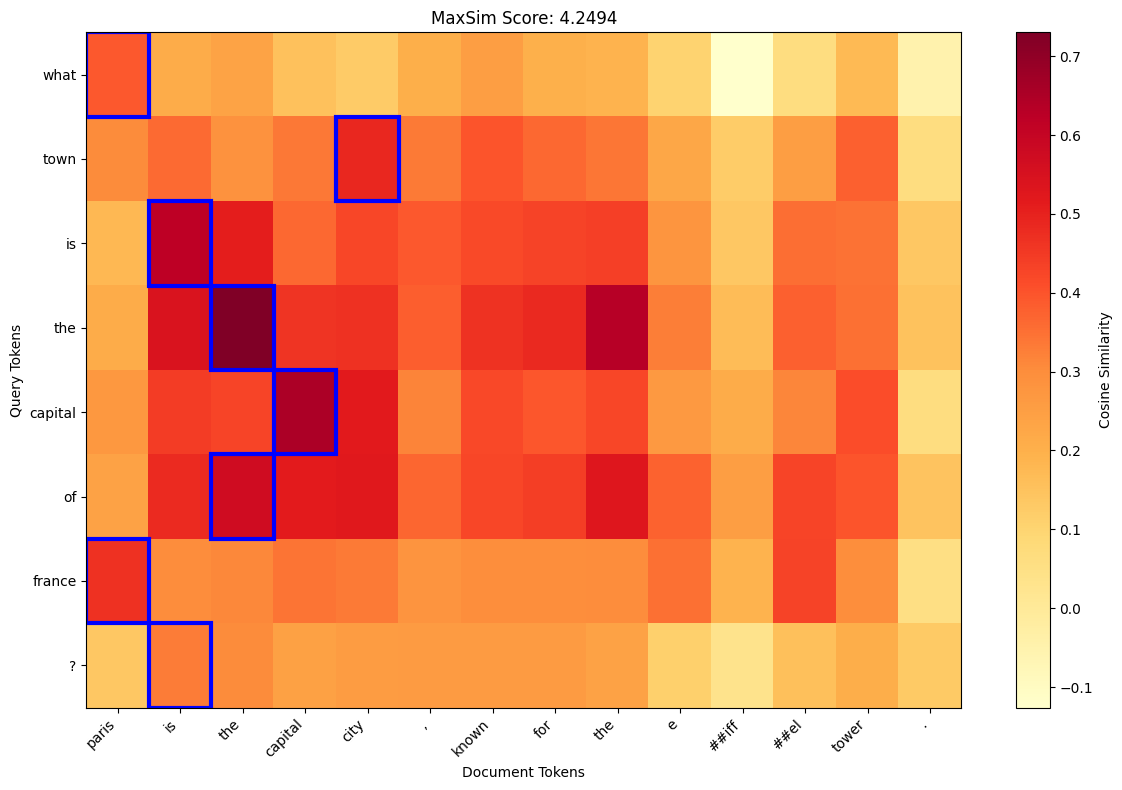


Top Contributing Query Tokens:
  'the' -> 'the' (similarity: 0.7303)
  'capital' -> 'capital' (similarity: 0.6509)
  'is' -> 'is' (similarity: 0.6174)
  'of' -> 'the' (similarity: 0.5716)
  'town' -> 'city' (similarity: 0.4894)


In [12]:
encoder = CustomLLMEncoder(model_name="bert-base-uncased")
analyze_query_document_interaction(
  encoder,
  "What town is the capital of France?",
  "Paris is the capital city, known for the Eiffel Tower."
)

## Summary

This notebook covered:

1. **Late Interaction Basics**: MaxSim scoring and multi-vector indexing
2. **ColBERTv2**: Token-level text embeddings for retrieval
3. **Custom LLM Encoders**: Using any transformer model for multi-vector search
4. **Detailed MaxSim Calculation**: Walk step-by step through a MaxSim calculation
5. **Visual Analysis**: Token contribution analysis and similarity visualization